In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
def remove_file(filename):
    try:
        os.remove(filename)
    except OSError as e:
        print(f"Error removing {filename}: {e}")

In [3]:
def convert_features(input_file):
    """
    Convert the 'Trade Date (US)' column to separate columns for 
    month, day, and year, and drop the original 'Trade Date (US)' column.

    Also, convert Offer To 1st Close to a binary classification (Underpriced
    column) and drop original column.
    """
    df = pd.read_csv(input_file)
    df['Trade Date (US)'] = pd.to_datetime(df['Trade Date (US)'])
    df['Trade Month'] = df['Trade Date (US)'].dt.month
    df['Trade Day'] = df['Trade Date (US)'].dt.day
    df['Trade Year'] = df['Trade Date (US)'].dt.year
    df.drop(columns=['Trade Date (US)'], inplace=True)
    df['Underpriced'] = df['Offer To 1st Close'].apply(lambda x: 1 if x < 0 else 0)
    df.drop(columns=['Offer To 1st Close'], inplace=True)
    return df

df_convert_features = convert_features('bloomberg_data.csv')

In [4]:
def drop_columns(columns,df):
    """
    Drop the specified columns from the DataFrame.
    """
    df = df.drop(columns=columns)
    return df

df_drop_columns = drop_columns(['Issuer Ticker',
                                'Issuer Name',
                                'Filing Term Price Range',
                                'cusip',
                                'Priced Range'],
                                df_convert_features)

In [5]:
def encoding(df):
    """
    Split the DataFrame into development and testing sets, using stratified sampling. 
    
    Fill missing values with the mode for categorical 
    columns and the mean for numerical columns.

    Encode columns in the DataFrame: 

      - Categorical columns are encoded using OneHotEncoder.
      - Numerical columns are scaled using StandardScaler.
      - Ordinal columns are encoded using OrdinalEncoder.

    Create df_dev and df_test using the transformed features.
    """

    X = df.drop(columns=['Underpriced'])
    y = df['Underpriced']

    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    if y_dev.isnull().any() or y_test.isnull().any():
        mean = y_dev.mean()
        y_dev = y_dev.fillna(mean)
        y_test = y_test.fillna(mean)

    for col in X_dev.columns:
        if X_dev[col].dtype == 'object':
            mode = X_dev[col].mode()[0]
            X_dev[col] = X_dev[col].fillna(mode)
            X_test[col] = X_test[col].fillna(mode)
        else:
            mean = X_dev[col].mean()
            X_dev[col] = X_dev[col].fillna(mean)
            X_test[col] = X_test[col].fillna(mean)


    oe_columns = ['Trade Month', 'Trade Day', 'Trade Year'] 
    ohe_columns = ['Industry Sector', 'Industry Group', 'Industry Subgroup']
    ss_columns = [col for col in X.select_dtypes(exclude=['object']).columns if col not in oe_columns]

    oe = OrdinalEncoder()
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ss = StandardScaler()

    preprocess = ColumnTransformer(transformers=[
        ('ohe', ohe, ohe_columns),
        ('ss', ss, ss_columns),
        ('oe', oe, oe_columns)
    ], remainder='passthrough')

    transformed_dev = preprocess.fit_transform(X_dev)
    transformed_test = preprocess.transform(X_test)

    features = preprocess.get_feature_names_out()

    df_dev = pd.DataFrame(transformed_dev, columns=features)
    df_test = pd.DataFrame(transformed_test, columns=features)

    df_dev['Underpriced'] = y_dev.reset_index(drop=True)
    df_test['Underpriced'] = y_test.reset_index(drop=True)

    return df_dev, df_test

df_dev_encoding, df_test_encoding = encoding(df_drop_columns)

In [6]:
def show_correlation(df_dev, df_test):
    """
    Check correlation in the X_dev column and drop highly correlated features.
    """
    X_dev = df_dev.drop(columns=['Underpriced'])
    y_dev = df_dev['Underpriced']

    X_test = df_test.drop(columns=['Underpriced'])
    y_test = df_test['Underpriced']

    corr_matrix = X_dev.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

    X_reduced = X_dev.drop(columns=to_drop)
    X_reduced_test = X_test.drop(columns=to_drop)

    df_dev = pd.concat([X_reduced, y_dev.reset_index(drop=True)], axis=1)
    df_test = pd.concat([X_reduced_test, y_test.reset_index(drop=True)], axis=1)

    print(f"Removed {len(to_drop)} correlated features.")
    df_test.to_csv('Final_Output_Class_test.csv', index=False)

    return df_dev, df_test

df_dev_correlation, df_test_correlation = show_correlation(df_dev_encoding, df_test_encoding)

Removed 29 correlated features.


Underpriced
0    2570
1     614
Name: count, dtype: int64

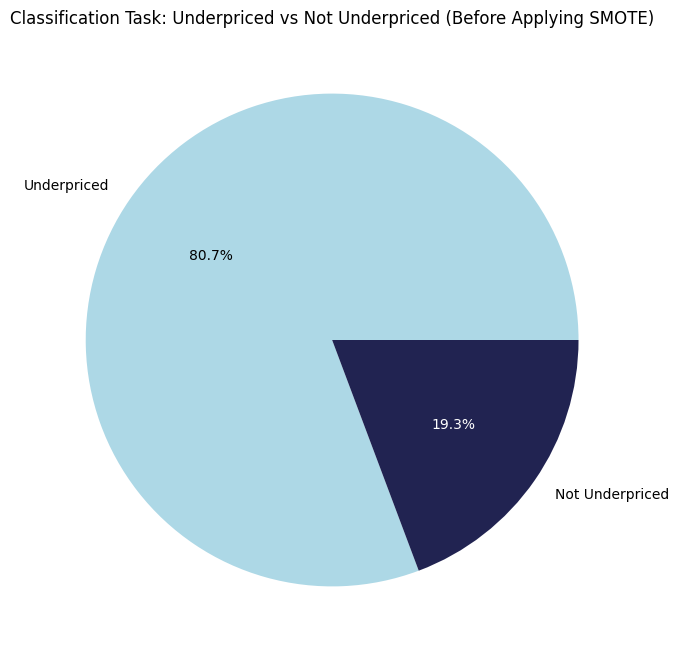

In [7]:
"""
Displaying pie plot to show target data imbalance.
"""

df = df_dev_correlation.copy()

plt.figure(figsize=(8, 8))
underpriced_counts = df['Underpriced'].value_counts()
display(underpriced_counts)
labels = ['Underpriced', 'Not Underpriced']
colors = ['lightblue', '#212351']

wedges, texts, autotexts = plt.pie(
    underpriced_counts, labels=labels, colors=colors,
    autopct='%1.1f%%', textprops={'color': 'black'}
)

for i, autotext in enumerate(autotexts):
    if colors[i] == '#212351':
        autotext.set_color('white')

plt.title('Classification Task: Underpriced vs Not Underpriced (Before Applying SMOTE)')
plt.show()


In [8]:
def checkimbalance(df, outfile):
    """
    Checking imbalance in the target data. 

    If imbalance, resample using SMOTE.
    """
    X_dev = df.drop(columns=['Underpriced'])
    y_dev = df['Underpriced']

    label_count_norm = df['Underpriced'].value_counts(normalize=True)
    label_count = df['Underpriced'].value_counts()
    print(f"Class distribution (normalized):\n{label_count_norm}\n")
    print(f"Class distribution:\n{label_count}\n")


    imbalance = abs(label_count_norm[0] - 0.5) > 0.1

    if imbalance:
        print('The data is imbalanced. Applying SMOTE...')
        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_dev, y_dev)
        df_final = pd.concat([X_resampled, y_resampled], axis=1)
        df_final.to_csv(outfile, index=False)
        print(f'The initial dataset had {y_dev.shape[0]} rows')
        print(f'The resampled dataset has {y_resampled.shape[0]} rows')
        print(f'Resampled feature matrix shape: {X_resampled.shape}')
        return df_final
    else:
        print('The data is balanced. No resampling applied.')
        return df

df_dev_resampled = checkimbalance(df_dev_correlation, 'Final_Output_Class_dev.csv')

Class distribution (normalized):
Underpriced
0    0.807161
1    0.192839
Name: proportion, dtype: float64

Class distribution:
Underpriced
0    2570
1     614
Name: count, dtype: int64

The data is imbalanced. Applying SMOTE...
The initial dataset had 3184 rows
The resampled dataset has 5140 rows
Resampled feature matrix shape: (5140, 387)
